In [146]:
import pandas as pd
from functools import reduce
import numpy as np
import impyute as impy
from sklearn.metrics import mean_squared_error,r2_score
import datawig
from ppca import PPCA
from fancyimpute import NuclearNormMinimization, MatrixFactorization
import matplotlib.pyplot as plt

#### Data Preparation

In [55]:
def readtodf(filename, colname):
    a=filename+'.txt'
    data = pd.read_csv(a, sep=",", header=(0))
    data.columns=['a','Date',colname]
    data=data.drop('a',axis=1)
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.set_index('Date')
    
    return data

In [56]:
target=readtodf('prod_target','Beer')
prod_1=readtodf('prod_1','Car')
prod_2=readtodf('prod_2','Steel')
eng_1=readtodf('eng_1','Gas')
eng_2=readtodf('eng_2','Electricity')

In [57]:
temp = pd.read_csv('temp.txt', sep=",", header=(0))
temp.columns=['num','year','month','Temp']
temp=temp.drop('num',axis=1)
temp['day']=1
temp['Date']=pd.to_datetime(temp[['year', 'month', 'day']])
temp=temp.drop(['year', 'month', 'day'],axis=1)
temp = temp.set_index('Date')

In [58]:
target.shape,prod_1.shape,prod_2.shape, eng_1.shape,eng_2.shape,temp.shape

((435, 1), (369, 1), (435, 1), (435, 1), (435, 1), (581, 1))

In [66]:
 # creat dataframe version of merged data
dfs = [target, prod_1, prod_2, eng_1,eng_2,temp]
df_final = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True,how='left'), dfs)
#df_final.to_csv('data_merged.csv')

# creat numpy version of merged data
np_final=np.array(df_final.values,dtype=np.float)

In [67]:
np_final.shape

(435, 6)

In [68]:
df_final.head()

,Beer,Car,Steel,Gas,Electricity,Temp
Date,,,,,,
1956-01-01,93.2,NaN,196.9,1709,1254,25.1
1956-02-01,96.0,NaN,192.1,1646,1290,25.3
1956-03-01,95.2,NaN,201.8,1794,1379,24.9
1956-04-01,77.1,NaN,186.9,1878,1346,23.9
1956-05-01,70.9,NaN,218.0,2173,1535,19.4


### Imputation

##### 1.Mice

The Multiple Imputation by Chained Equations (MICE) method is widely used in practice, which uses chain equations to create multiple imputations for variables of diferent types.

In [154]:
ip_mice=impy.imputation.cs.mice(np_final)
#np.savetxt('./Imputation Results/imputation_mice.csv',ip_mice,delimiter=",")

##### 2.KNN

- This method uses k-nearest neighbor to fInd similar samples and imputed unobserved data by weighted average of similar observations.
- Basic idea: Impute array with a basic mean impute and then use the resulting complete array to construct a KDTree. Use this KDTree to compute nearest neighbours. After finding k nearest neighbours, take the weighted average of them. Basically, find the nearest row in terms of distance

In [124]:
ip_knn=impy.imputation.cs.fast_knn(np_final)
#np.savetxt('./Imputation Results/imputation_knn.csv',ip_knn,delimiter=",")

##### 3.NuclearNormMinimization

Simple implementation of Exact Matrix Completion via Convex Optimization by Emmanuel Candes and Benjamin Recht using cvxpy. Too slow for large matrices.

In [26]:
X_filled_nnm = NuclearNormMinimization().fit_transform(np_final)

----------------------------------------------------------------------------
	SCS v2.1.0 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 115539
eps = 1.00e-04, alpha = 1.50, max_iters = 50000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 102681, constraints m = 107901
Cones:	primal zero / dual free vars: 2610
	linear vars: 7830
	sd vars: 97461, sd blks: 1
Setup time: 7.49e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.43e+21  4.09e+21  1.00e+00 -3.84e+28  6.77e+27  8.25e+27  7.91e-02 
   100| 9.26e-04  9.60e-04  1.00e-04  1.02e+06  1.02e+06  5.96e-10  5.29e+00 
   200| 4.07e-04  3.60e-04  2.09e-04  1.02e+06  1.0

In [139]:
ip_nnm=X_filled_nnm

In [137]:
#np.savetxt('./Imputation Results/imputation_NuclearNormMinimization.csv',ipp_nnm,delimiter=",")

##### 4.MatrixFactorization

Direct factorization of the incomplete matrix into low-rank U and V, with an L1 sparsity penalty on the elements of U and an L2 penalty on the elements of V. Solved by gradient descent.

In [73]:
missing_value_mask=np.ma.getmaskarray(np.ma.masked_invalid(np_final))

In [75]:
np.savetxt('Mask.csv',missing_value_mask,delimiter=',')

In [ ]:
ip_mf=MatrixFactorization().solve(X=np_final.copy(),missing_mask=missing_value_mask)

In [79]:
np.savetxt('./Imputation Results/imputation_matrixfactorization.csv',ip_mf,delimiter=",")

##### 5.DataWig

- "Deep" Learning for Missing Value Imputationin Tables with Non-Numerical Data
- Details on the underlying model can be found in [Biessmann, Salinas et al. 2018](https://dl.acm.org/citation.cfm?id=3272005)

In [98]:
#Initialize a SimpleImputer model
imputer = datawig.SimpleImputer(
    input_columns=['Car','Steel','Gas','Electricity','Temp'], # column(s) containing information about the column we want to impute
    output_column='Beer', # the column we'd like to impute values for
    output_path = 'imputer_model' # stores model data and metrics
    )

#Using LSTMs instead of bag-of-words
# data_encoder_cols = [NumericalEncoder('Car'), NumericalEncoder('Steel'),NumericalEncoder('Gas'),\
#                     NumericalEncoder('Electricity'),NumericalEncoder('Temp')]
# label_encoder_cols = [NumericalEncoder('Beer')]
# data_featurizer_cols = [LSTMFeaturizer('Car'), LSTMFeaturizer('Steel'),LSTMFeaturizer('Gas'),\
#                     LSTMFeaturizer('Electricity'),LSTMFeaturizer('Temp')]

# imputer = Imputer(
#     data_featurizers=data_featurizer_cols,
#     label_encoders=label_encoder_cols,
#     data_encoders=data_encoder_cols,
#     output_path='imputer_model'
# )

In [99]:
#Fit an imputer model on the train data
imputer.fit(train_df=df_final[df_final['Beer'].notnull()], num_epochs=300,learning_rate=1e-3,batch_size=5,weight_decay=1e-4)

2019-04-23 22:51:09,210 [INFO]  Assuming 5 numeric input columns: Car, Steel, Gas, Electricity, Temp
2019-04-23 22:51:09,211 [INFO]  Assuming 0 string input columns: 
2019-04-23 22:51:09,212 [INFO]  No output column name provided for ColumnEncoder using Beer
2019-04-23 22:51:09,214 [INFO]  Assuming numeric output column: Beer
2019-04-23 22:51:09,215 [INFO]  Using [[cpu(0)]] as the context for training
2019-04-23 22:51:09,218 [INFO]  Fitting label encoder <class 'datawig.column_encoders.NumericalEncoder'> on 364 rows                             of training data
2019-04-23 22:51:09,222 [INFO]  Detected 0 rows with missing labels                         for column Beer
2019-04-23 22:51:09,224 [INFO]  Dropping 0/364 rows
2019-04-23 22:51:09,225 [INFO]  Detected 0 rows with missing labels                         for column Beer
2019-04-23 22:51:09,226 [INFO]  Dropping 0/40 rows
2019-04-23 22:51:09,227 [INFO]  Train: 364, Test: 40
2019-04-23 22:51:09,228 [INFO]  Fitting data encoder <class '

In [100]:
#Impute missing values and return original dataframe with predictions
imputed = imputer.predict(df_final)
#imputed.to_csv('./Imputation Results/imputation_Datawig.csv')

2019-04-23 22:51:11,473 [INFO]  Concatenating numeric columns ['Car', 'Steel', 'Gas', 'Electricity', 'Temp'] into numerical_features-q6ITZM5jtg
2019-04-23 22:51:11,474 [INFO]  Normalizing with StandardScaler
2019-04-23 22:51:11,477 [INFO]  Data Encoding - Encoded 435 rows of column                         Car,Steel,Gas,Electricity,Temp with <class 'datawig.column_encoders.NumericalEncoder'> into                         <class 'numpy.ndarray'> of shape (435, 5)                         and then into shape (435, 5)
2019-04-23 22:51:11,479 [INFO]  Concatenating numeric columns ['Beer'] into Beer
2019-04-23 22:51:11,480 [INFO]  Normalizing with StandardScaler
2019-04-23 22:51:11,483 [INFO]  Label Encoding - Encoded 435 rows of column                             Beer with <class 'datawig.column_encoders.NumericalEncoder'> into                             <class 'numpy.ndarray'> of shape (435, 1) and                             then into shape (435, 1)
2019-04-23 22:51:11,520 [INFO]  Top-k on

In [101]:
predictions=imputed[imputed['Beer'].notnull()]

In [102]:
#Calculate MSE score
MSE = mean_squared_error(predictions['Beer'].values, predictions['Beer_imputed'].values)

#Calculate r2 score
r2=r2_score(predictions['Beer'].values, predictions['Beer_imputed'].values)

MSE,r2

(219.16279303390607, 0.8194381788846463)

In [103]:
imputed_data=imputed.copy()
imputed_data.loc['1972-09-01':'1975-02-01','Beer']=imputed.loc['1972-09-01':'1975-02-01']['Beer_imputed'].values
imputed_data=imputed_data.drop('Beer_imputed',axis=1);

The beer data has been imputed

In [104]:
imputed_data.head()

,Beer,Car,Steel,Gas,Electricity,Temp
Date,,,,,,
1956-01-01,93.2,NaN,196.9,1709,1254,25.1
1956-02-01,96.0,NaN,192.1,1646,1290,25.3
1956-03-01,95.2,NaN,201.8,1794,1379,24.9
1956-04-01,77.1,NaN,186.9,1878,1346,23.9
1956-05-01,70.9,NaN,218.0,2173,1535,19.4


Now, we would like to impute the Car.

In [114]:
#Initialize a SimpleImputer model
imputer = datawig.SimpleImputer(
    input_columns=['Beer','Steel','Gas','Electricity','Temp'], # column(s) containing information about the column we want to impute
    output_column='Car', # the column we'd like to impute values for
    output_path = 'imputer_model' # stores model data and metrics
    )

In [115]:
#Fit an imputer model on the train data
imputer.fit(train_df=imputed_data[imputed_data['Car'].notnull()], num_epochs=300)

2019-04-23 22:55:22,739 [INFO]  Assuming 5 numeric input columns: Beer, Steel, Gas, Electricity, Temp
2019-04-23 22:55:22,740 [INFO]  Assuming 0 string input columns: 
2019-04-23 22:55:22,742 [INFO]  No output column name provided for ColumnEncoder using Car
2019-04-23 22:55:22,743 [INFO]  Assuming numeric output column: Car
2019-04-23 22:55:22,745 [INFO]  Using [[cpu(0)]] as the context for training
2019-04-23 22:55:22,747 [INFO]  Fitting label encoder <class 'datawig.column_encoders.NumericalEncoder'> on 332 rows                             of training data
2019-04-23 22:55:22,751 [INFO]  Detected 0 rows with missing labels                         for column Car
2019-04-23 22:55:22,752 [INFO]  Dropping 0/332 rows
2019-04-23 22:55:22,754 [INFO]  Detected 0 rows with missing labels                         for column Car
2019-04-23 22:55:22,755 [INFO]  Dropping 0/36 rows
2019-04-23 22:55:22,757 [INFO]  Train: 332, Test: 36
2019-04-23 22:55:22,759 [INFO]  Fitting data encoder <class 'dat

In [116]:
#Impute missing values and return original dataframe with predictions
imputed_car = imputer.predict(imputed_data)
#imputed.to_csv('./Imputation Results/imputation_Datawig.csv')

2019-04-23 22:55:27,523 [INFO]  Concatenating numeric columns ['Beer', 'Steel', 'Gas', 'Electricity', 'Temp'] into numerical_features-BuNO6n9JEC
2019-04-23 22:55:27,525 [INFO]  Normalizing with StandardScaler
2019-04-23 22:55:27,527 [INFO]  Data Encoding - Encoded 448 rows of column                         Beer,Steel,Gas,Electricity,Temp with <class 'datawig.column_encoders.NumericalEncoder'> into                         <class 'numpy.ndarray'> of shape (448, 5)                         and then into shape (448, 5)
2019-04-23 22:55:27,529 [INFO]  Concatenating numeric columns ['Car'] into Car
2019-04-23 22:55:27,531 [INFO]  Normalizing with StandardScaler
2019-04-23 22:55:27,534 [INFO]  Label Encoding - Encoded 448 rows of column                             Car with <class 'datawig.column_encoders.NumericalEncoder'> into                             <class 'numpy.ndarray'> of shape (448, 1) and                             then into shape (448, 1)
2019-04-23 22:55:27,548 [INFO]  Top-k onl

In [118]:
imputed_car.head()

,Beer,Car,Steel,Gas,Electricity,Temp,Car_imputed
Date,,,,,,,
1956-01-01,93.2,NaN,196.9,1709,1254,25.1,13353.124051
1956-02-01,96.0,NaN,192.1,1646,1290,25.3,13402.324907
1956-03-01,95.2,NaN,201.8,1794,1379,24.9,13847.022922
1956-04-01,77.1,NaN,186.9,1878,1346,23.9,12600.094446
1956-05-01,70.9,NaN,218.0,2173,1535,19.4,15945.470801


In [119]:
imputed_data_final=imputed_car.copy()
imputed_data_final.loc['1956-01-01':'1961-06-01','Car']=\
imputed_car.loc['1956-01-01':'1961-06-01']['Car_imputed'].values
imputed_data_final=imputed_data_final.drop('Car_imputed',axis=1)

In [142]:
ip_dp=imputed_data_final.values

In [121]:
#imputed_data_final.to_csv('./Imputation Results/imputation_Datawig.csv',sep=',')

### Summary

In [133]:
np.round(ip_mice[200:230,0],3)

array([133.758, 133.758, 133.758, 133.758, 133.758, 133.758, 133.758,
       133.758, 133.758, 133.758, 133.758, 133.758, 133.758, 133.758,
       133.758, 133.758, 133.758, 133.758, 133.758, 133.758, 133.758,
       133.758, 133.758, 133.758, 133.758, 133.758, 133.758, 133.758,
       133.758, 133.758])

In [134]:
np.round(ip_knn[200:230,0],3)

array([133.758, 129.104, 133.758, 133.758, 135.488, 129.983, 130.215,
       133.758, 129.803, 175.662, 141.758, 149.548, 132.011, 132.106,
       129.229, 133.758, 150.656, 133.758, 123.799, 130.759, 144.196,
       150.885, 144.218, 155.397, 150.754, 146.004, 145.522, 143.889,
       154.777, 158.783])

In [140]:
np.round(ip_nnm[200:230,0],3)

array([143.782, 150.655, 150.764, 148.602, 145.189, 135.655, 152.186,
       147.568, 153.941, 126.864, 159.759, 160.414, 157.489, 161.279,
       156.479, 165.273, 161.103, 151.244, 159.9  , 134.902, 139.134,
       136.605, 160.229, 157.891, 151.45 , 170.61 , 165.908, 170.979,
       158.989, 157.011])

In [141]:
np.round(ip_mf[200:230,0],3)

array([130.566, 130.75 , 132.392, 129.175, 132.195, 131.735, 130.198,
       129.813, 130.451, 129.507, 129.711, 130.739, 131.133, 130.305,
       132.024, 130.099, 139.08 , 129.856, 130.407, 129.558, 131.656,
       140.283, 128.175, 140.852, 129.208, 130.528, 131.4  , 129.286,
       140.414, 129.313])

In [144]:
np.round(ip_dp[200:230,0],3)

array([142.715, 147.973, 153.867, 166.59 , 158.615, 153.579, 166.996,
       156.653, 152.112, 110.034, 136.355, 145.243, 156.285, 164.192,
       165.443, 179.951, 165.727, 166.123, 172.743, 146.52 , 140.887,
       122.871, 139.094, 134.443, 142.683, 163.654, 163.183, 183.122,
       164.731, 172.646])

Text(0, 0.5, 'Beer Production')

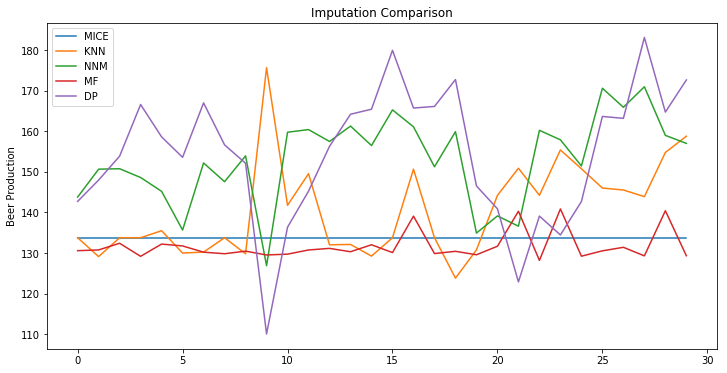

In [159]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(ip_mice[200:230,0],label='MICE')
plt.plot(ip_knn[200:230,0],label='KNN')
plt.plot(ip_nnm[200:230,0],label='NNM')
plt.plot(ip_mf[200:230,0],label='MF')
plt.plot(ip_dp[200:230,0],label='DP')
plt.legend()
plt.title('Imputation Comparison')
plt.ylabel('Beer Production')